## Настройка среды

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
from scipy import stats

In [3]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [4]:
import lightgbm as lgb

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, layers

In [6]:
sb.set()

In [7]:
DATA_DIR = Path("/datasets/final_provider/")

## Загрузка данных

### contract

In [8]:
contract = pd.read_csv(DATA_DIR.joinpath("contract.csv"), parse_dates=["BeginDate"], index_col="customerID")

# Count NA values before dtype convertion
na_count_EndDate = (contract["EndDate"] == "No").sum()
na_count_TotalCharges = (contract["TotalCharges"] == " ").sum()
# Convert column dtypes
contract["EndDate"] = pd.to_datetime(arg=contract["EndDate"], errors="coerce", yearfirst=True, format="%Y-%m-%d")
contract["TotalCharges"] = pd.to_numeric(contract["TotalCharges"], errors="coerce")
# Check are changes correct
assert na_count_EndDate + contract["EndDate"].count() == contract.shape[0]
assert na_count_TotalCharges + contract["TotalCharges"].count() == contract.shape[0]

contract.info()
contract.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1869 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 440.2+ KB


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
8329-UTMVM,2017-11-01,NaT,One year,Yes,Bank transfer (automatic),104.65,2964.00
4881-GQJTW,2018-12-01,NaT,Month-to-month,No,Credit card (automatic),19.60,300.40
5117-IFGPS,2017-09-01,NaT,Month-to-month,Yes,Electronic check,84.30,2357.75
0508-SQWPL,2015-05-01,NaT,Two year,Yes,Bank transfer (automatic),20.10,1087.70
2606-PKWJB,2016-10-01,NaT,One year,No,Mailed check,40.25,1564.05


In [9]:
contract.describe(include="number")

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


In [10]:
contract.describe(include="object")

,Type,PaperlessBilling,PaymentMethod
count,7043,7043,7043
unique,3,2,4
top,Month-to-month,Yes,Electronic check
freq,3875,4171,2365


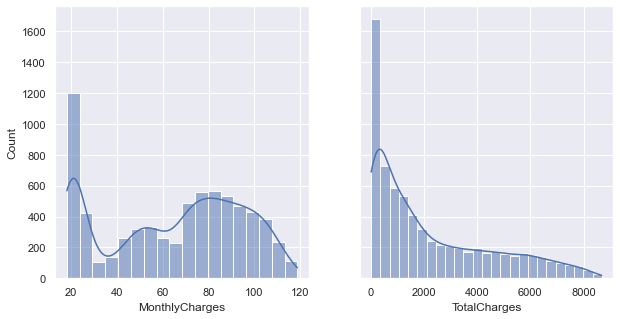

In [11]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
for colname, ax in zip(["MonthlyCharges", "TotalCharges"], axs.flat):
    sb.histplot(data=contract, x=colname, kde=True, ax=ax)

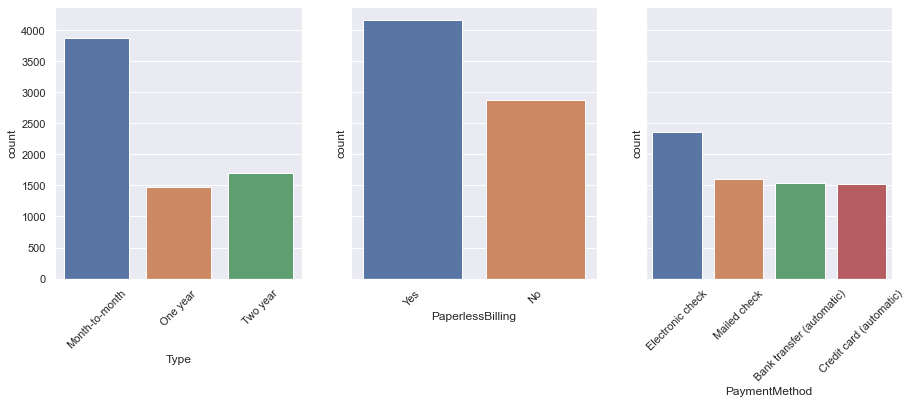

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
for colname, ax in zip(["Type", "PaperlessBilling", "PaymentMethod"], axs):
    sb.countplot(x=contract[colname], ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    

**Выводы**

1. В колонке 'EndDate' есть пропуски. Скорее всего пропуск означают действующих клиентов, а заполненные ячейки принадлежат клиентам закрывшим контрат с провайдером.
2. В колонке 'TotalCharges' есть пропуски. Скорее всего это новые клиенты, заключившие контракт в текущем месяце, и для них заполнить расходы еще не успели. Думаю можно заполнить эти пропуски значением из колонки 'MonthlyCharges', либо удалить строки с пропусками (всего 11), что проще.
3. Распределения клиентских счетов визуально отличаются от нормальных, как ежемесячных так и общих. Кроме того средний размер общих счетов (медиана) сильно ниже максимального значения. Скорее всего разные "горбы" на гистограммах и разница между средним и максимальным счетами означают возможность выделения нескольких групп клиентов по величинам счетов.
4. По количественной диаграмме 'Type' видно, что большая часть клиентов оплачивает счета в режиме ежемесячных отчислений.
5. Даты в колонках 'BeginDate', 'EndDate' приведены к нужному формату дат.

### personal

In [13]:
personal = pd.read_csv(DATA_DIR.joinpath("personal.csv"), index_col="customerID")
personal.info()
personal.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
4576-CSAJH,Male,0,No,No
2758-RNWXS,Male,0,No,No
7595-EHCDL,Male,0,Yes,Yes
9490-DFPMD,Female,1,No,No
4538-WNTMJ,Female,0,Yes,Yes


In [14]:
personal.describe(include="number")

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [15]:
personal.describe(include="object")

,gender,Partner,Dependents
count,7043,7043,7043
unique,2,2,2
top,Male,No,No
freq,3555,3641,4933


In [16]:
print(
    "Совпадают ли индексы 'contract' и 'personal':",
    contract.index.equals(personal.index)
)

Совпадают ли индексы 'contract' и 'personal': True


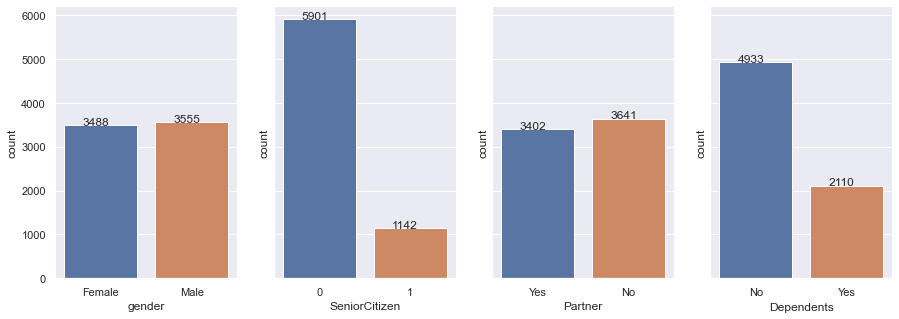

In [17]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 5))
for colname, ax in zip(personal.columns, axs):
    sb.countplot(x=personal[colname], ax=ax)
    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x() + .2, p.get_height()))

**Выводы**

1. В данных пропусков не обнаружено.
2. Группы клиентов по половой принадлежности (признак 'gender') и наличию супруга(и) (признак 'Partner') сбаласированны.
3. Лишь седьмая часть клиентов - пожилые люди (признак 'SeniorCitizen'). Т.е. большая часть клиентов молодежь и люди зрелого возраста.
4. Клиентов без детей (признак 'Dependents') примерно в 2.3 раза больше, чем с детьми.

### internet

In [18]:
internet = pd.read_csv(DATA_DIR.joinpath("internet.csv"), index_col="customerID")
internet.info()
internet.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
5149-TGWDZ,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
0654-HMSHN,Fiber optic,No,Yes,Yes,No,Yes,Yes
2988-PLAHS,DSL,No,No,Yes,No,Yes,Yes
9866-OCCKE,Fiber optic,Yes,No,Yes,Yes,Yes,Yes
9968-FFVVH,DSL,Yes,Yes,Yes,Yes,No,No


In [19]:
internet.describe()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


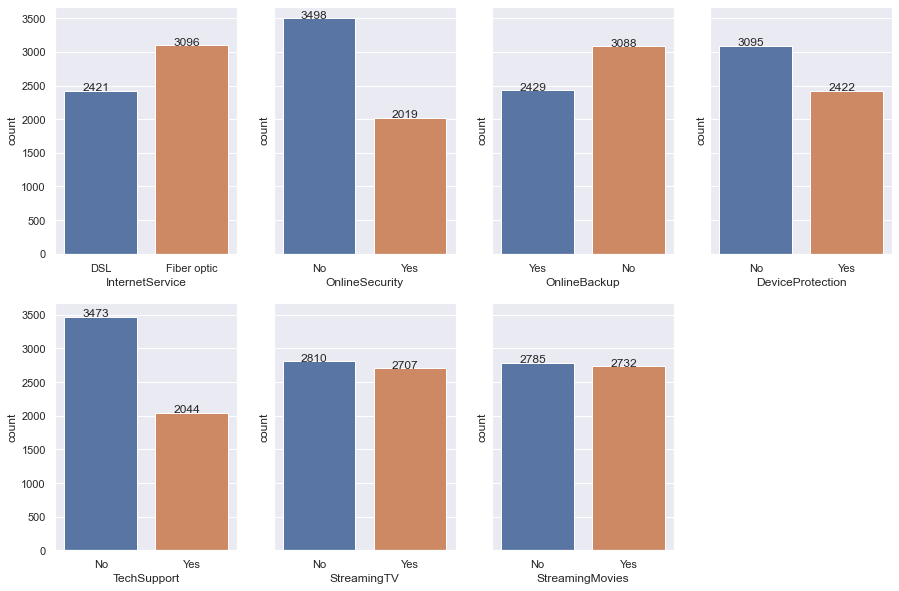

In [20]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(15, 10))
fig.delaxes(axs.flat[-1])

for colname, ax in zip(internet.columns, axs.flat):
    sb.countplot(x=internet[colname], ax=ax)
    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x() + .2, p.get_height()))

**Выводы**
1. В данных пропусков нет.
2. Все признаки категориальные с двумя значениями.
3. Все признаки более-меннее сбалансированы. 

### phone

In [21]:
phone = pd.read_csv(DATA_DIR.joinpath("phone.csv"), index_col="customerID")
phone.info()
phone.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


,MultipleLines
customerID,
4682-BLBUC,No
4395-PZMSN,No
8563-OYMQY,No
0236-HFWSV,Yes
0384-RVBPI,No


In [22]:
phone.describe()

,MultipleLines
count,6361
unique,2
top,No
freq,3390


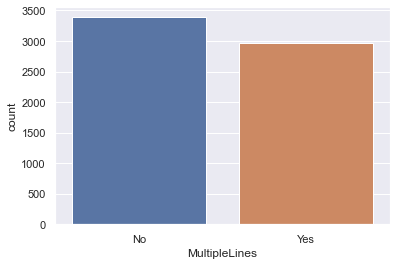

In [23]:
_ = sb.countplot(x=phone["MultipleLines"])

**Выводы**

1. Пропусков нет.
2. Группы пользователей по наличию нескольких линий сбалансированны.

## Анализ

### Графики

Для удобства добавим некоторые признаки в данные о договорах: наличие интернет услуг, наличие услуг телефонии, закрыт ли договор.

In [24]:
contract["HasInternet"] = contract.index.isin(internet.index)
contract["HasPhone"] = contract.index.isin(phone.index)
contract["HasLeft"] = contract["EndDate"].notna()

In [25]:
print("Всего ушедших клиентов\n")
print("Количество:", contract["HasLeft"].sum())
print("Доля: {:.1%}".format(contract["HasLeft"].sum() / contract.shape[0]))

Всего ушедших клиентов

Количество: 1869
Доля: 26.5%


За исследуемый промежуток времени с компанией расторгло договор 26.5% клиентов (примерно четверть). При решении задачи классификации, это означает дисбаланс классов.

In [26]:
print("Количество и доля клиентов, пользующихся следующими услугами\n")
client_ip_count = contract.query("HasInternet & HasPhone").shape[0]
client_i_count  = contract.query("HasInternet & ~HasPhone").shape[0]
client_p_count  = contract.query("~HasInternet & HasPhone").shape[0]
print("Интернет и телефония: {:4}, {:5.1%}".format(client_ip_count, client_ip_count / contract.shape[0]))
print("Только интернет:      {:4}, {:5.1%}".format(client_i_count,  client_i_count  / contract.shape[0]))
print("Только телефония:     {:4}, {:5.1%}".format(client_p_count,  client_p_count  / contract.shape[0]))

assert sum((client_ip_count, client_i_count, client_p_count)) == contract.shape[0]

Количество и доля клиентов, пользующихся следующими услугами

Интернет и телефония: 4835, 68.6%
Только интернет:       682,  9.7%
Только телефония:     1526, 21.7%


Большая часть клиентов пользуется услугами и интернет, и телефонии.

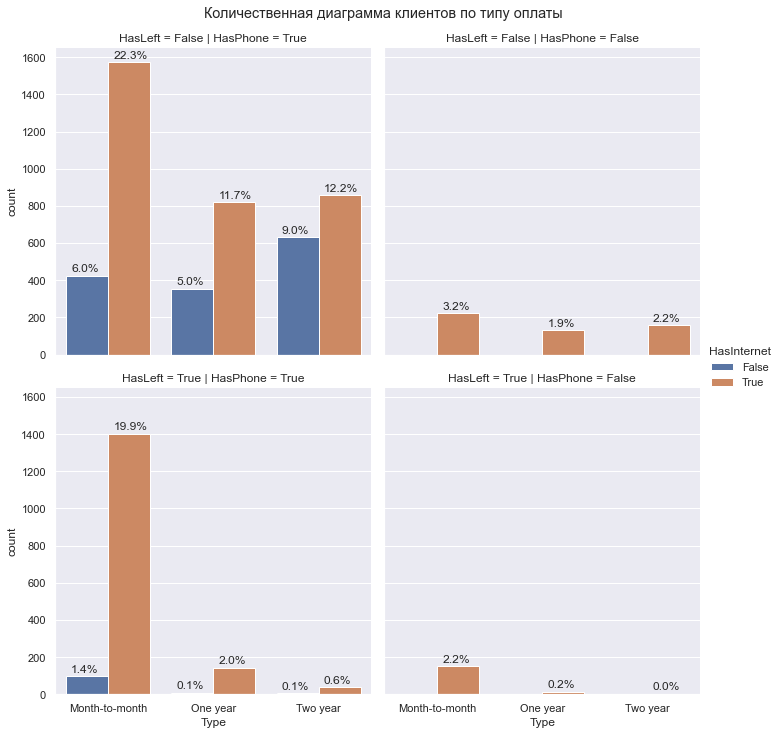

In [27]:
fgrid = sb.catplot(
    data=contract, 
    hue="HasInternet", 
    x="Type", 
    col="HasPhone", 
    row="HasLeft", 
    kind="count", 
    col_order=[True, False]
)
fgrid.figure.suptitle("Количественная диаграмма клиентов по типу оплаты", va='bottom', y=1)

for ax in fgrid.axes.flat:
    # Drop empty axes
    if not ax.has_data():
        fgrid.figure.delaxes(ax)
    # Add annotation
    for p in ax.patches:
        ax.annotate(
            "{:.1%}".format(p.get_height() / contract.shape[0]), 
            xy=(p.get_x()+.05, p.get_height()+20)
        )

Подавляющая часть ушедших клиентов, примерно 75% от общего числа ушедших клиентов, пользовалась услугами интернет и телефонии в режиме помесячной оплаты. Подозреваю, что стоит обратить внимание именно на ежемесячные тарифы. Посмотрим на распределения ежемесячных клиентских счетов.

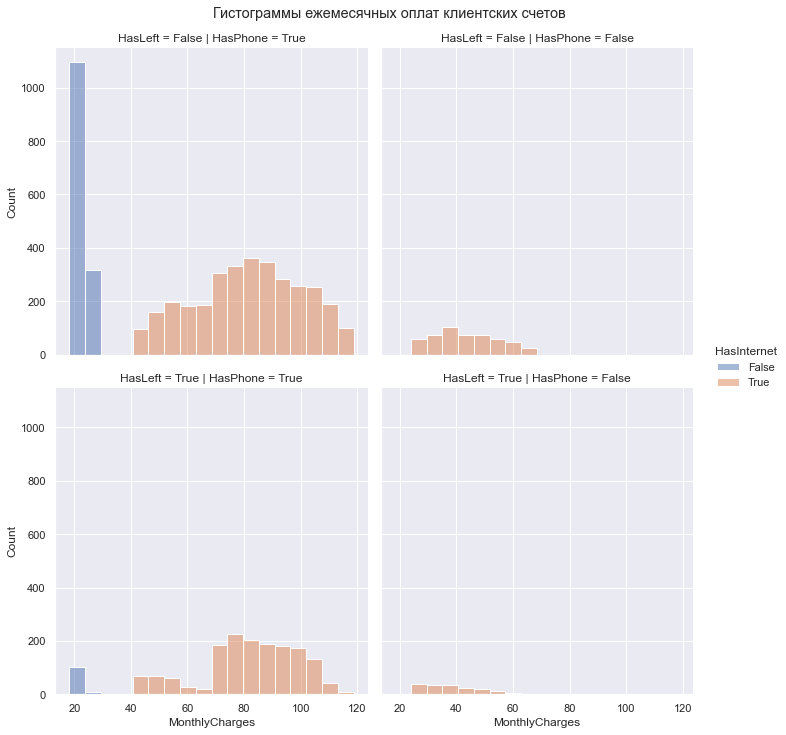

In [28]:
fgrid = sb.displot(
    data=contract, 
    x="MonthlyCharges", 
    hue="HasInternet", 
    row="HasLeft", 
    col="HasPhone", 
    kind="hist", 
    col_order=[True, False],
)
_ = fgrid.figure.suptitle("Гистограммы ежемесячных оплат клиентских счетов", va='bottom', y=1)

После разделения клиентов на по платежам по основным услугам провайдера выделилось несколько разных групп с разными распределениями среди действующих клиентов и клиентов расторгнувших договор:

1. Клиенты пользующиеся услугами интернета и телефонии (действующие/ушедшие), составляющие подавляющее большинство.
2. Клиенты пользующиеся только услугами интернета (действующие/ушедшие).
3. Клиенты пользующиеся только услугами телефонии (действующие/ушедшие).

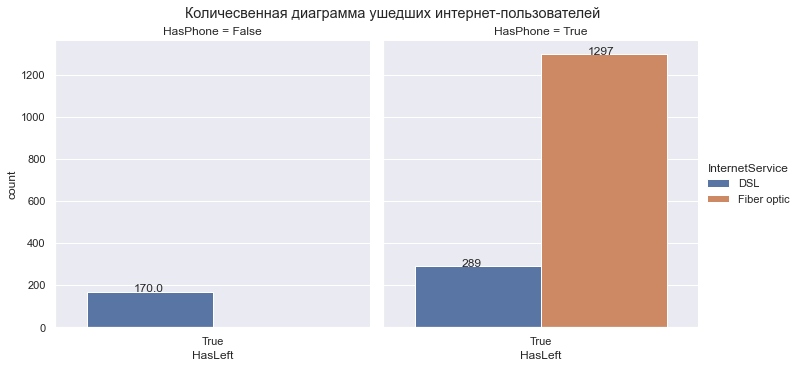

In [29]:
fgrid = sb.catplot(
    data=contract.merge(internet, how='inner', on="customerID").query("HasLeft"),
    x="HasLeft",
    hue="InternetService",
    col="HasPhone",
    kind="count",
)
fgrid.figure.suptitle(
    "Количесвенная диаграмма ушедших интернет-пользователей",
    va='bottom'
)
for ax in fgrid.axes.ravel():
    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+.15, p.get_height()))

Большая часть, примерно две трети, ушедших интернет-клиентов пользовалась оптическим каналом (который, возможно, должен обеспечивать большую скорость передачи данных в отличае от DSL) и пользовалась услугами телефонии.

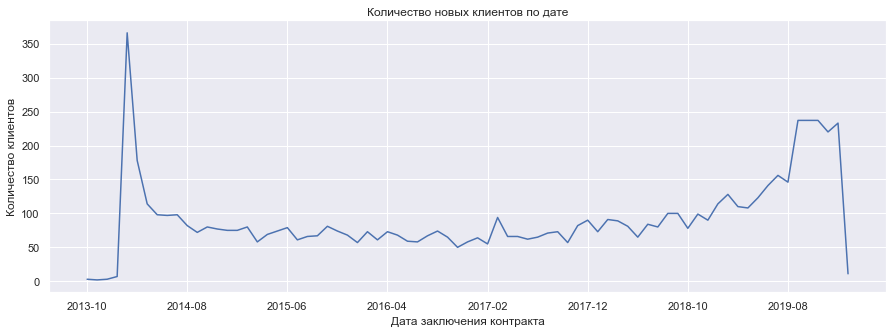

In [30]:
contract_start = contract.pivot_table(index="BeginDate", values="Type", aggfunc="count")
contract_start.index = contract_start.index.strftime("%Y-%m")
ax = contract_start.plot(
    ylabel="Количество клиентов",
    xlabel="Дата заключения контракта",
    legend=False,
    title="Количество новых клиентов по дате",
)
ax.figure.set_size_inches(15, 5)
# Clean
del contract_start

В начале 2014 года и в конце 2019 наблюдаются рост количества новых договоров. 

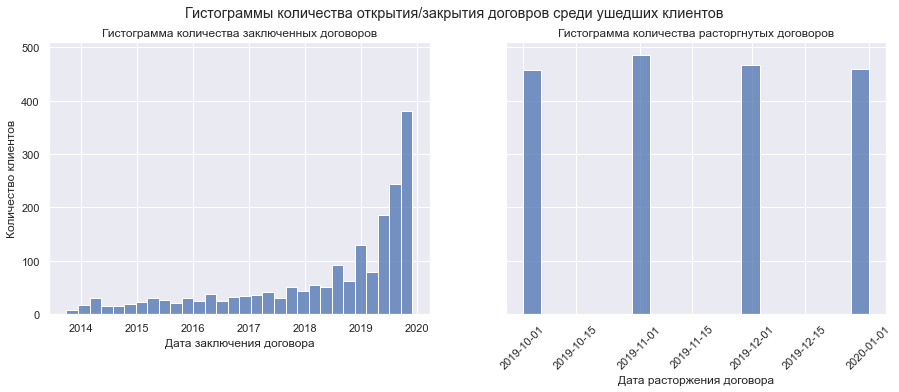

In [31]:
contract_closed = contract.query("HasLeft")

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

sb.histplot(data=contract_closed, x="BeginDate", bins=30, ax=axs[0])
sb.histplot(data=contract_closed, x="EndDate",  ax=axs[1])

axs[0].set_title("Гистограмма количества заключенных договоров")
axs[0].set_xlabel("Дата заключения договора")
axs[0].set_ylabel("Количество клиентов")

axs[1].set_title("Гистограмма количества расторгнутых договоров")
axs[1].set_xlabel("Дата расторжения договора")
axs[1].tick_params(axis='x', rotation=45)

fig.suptitle("Гистограммы количества открытия/закрытия договров среди ушедших клиентов")

del contract_closed

Наблюдается растущий тренд заключения новых договоров особенно заметный с начала 2019 года, наряду с большим количеством расторгнутых договоров с октября 2019 года по январь 2020 года.

### Выводы

1. За исследуемый период с компанией расторгло договор 26.5% клиентов (примерно четверть). Это произошлло с октября 2019 года по январь 2020 года (4 месяца).
2. В начале 2014 года и в конце 2019 наблюдаются рост количества новых договоров. Это может быть связано с сезонными тендециями, либо с переходом на другие условия по договору, либо ЧП и т.д.
3. Выделено 6 групп клиентов по ежемесячным платежам и основным услугам провайдера 
4. Лишь маленькая часть ушедших клиентов, примерно 5% или 1.4% от всей выборки, не пользовалась услугами интернета!
5. Большая часть, примерно две трети, ушедших интернет-клиентов пользовалась оптическим каналом (который, возможно, должен обеспечивать большую скорость передачи данных в отличае от DSL) и пользовалась услугами телефонии.
6. Среди ушедших наблюдается растущий тренд заключения новых договоров особенно заметный с начала 2019 года, наряду с большим количеством расторгнутых договоров с октября 2019 года по январь 2020 года.
7. Среди ушедших много клиентов заключило договор с провайдером во второй половине 2019 года, а затем через несколько месяцев клиенты расторгли договор. Есть клиенты, которые были с компанией с 2013 года, таких меньше. Может стоит обратить внимание на конкурентов?
8. Дисбаланс классов действующих/ушедших клиентов.


### Статистика

Соберем статистики для выделенных групп клиентов.

In [32]:
monthly_charges_stats = (contract
    .groupby(["HasLeft", "HasInternet", "HasPhone"])
    .agg({"MonthlyCharges": 
        ['count', 
         'mean', 
         'std',
         'min', 
         lambda s: s.quantile(q=.25),
         'median',
         lambda s: s.quantile(q=.75),
         'max']})
    .transpose())

monthly_charges_stats.index = pd.Index(
    ['count', 'mean', 'std','min', "25%",'median',"50%",'max'], 
    name="MonthlyCharges"
)
monthly_charges_stats

HasLeft               False                                 True              \
HasInternet           False        True                    False        True   
HasPhone               True       False         True        True       False   
MonthlyCharges                                                                 
count           1413.000000  512.000000  3249.000000  113.000000  170.000000   
mean              21.136058   43.520996    81.513620   20.368142   37.533824   
std                2.201510   11.471209    18.883664    1.456851   10.026727   
min               18.250000   24.150000    43.450000   18.850000   23.450000   
25%               19.700000   34.837500    68.150000   19.650000   29.662500   
median            20.150000   43.775000    81.500000   20.000000   35.500000   
50%               21.000000   52.662500    95.950000   20.350000   45.250000   
max               26.900000   67.200000   118.750000   25.900000   60.450000   

HasLeft                      
HasInternet                  
HasPhone               True  
MonthlyCharges               
count           1586.000000  
mean              82.250000  
std               17.047215  
min               42.900000  
25%               72.212500  
median            84.125000  
50%               95.450000  
max              118.350000

- Большую часть ежемесячного притока денег провайдеру обеспечивают клиенты первой группы (интернет + телефония) с медианными счетами 81.5/84.1 денежных единиц (действующие/ушедшие) и среднеквадратическим отклоненимем в 18.8/17 денежных единиц.
- На втором месте клиенты второй группы с медианой счета 43.8/35.5 денежных единиц (действующие/ушедшие)) и среднеквадратическим отклоненимем 11/10 денежных единиц.
- И замыкают парад прибыли клиенты телефонии с медийными счетами в 20 денежных единиц и среднеквадратическим отклоненимем 2.2/1.5 денежных единиц.

Сравним распределения ежемесячных счетов действующих и ушедших клиентов по группам услуг интернет и телефонии.

In [33]:
def distribution_equals(sample1, sample2, alpha=.05):
    print("Проверка нулевой гипотезы о равенстве средних двух выборок")
    statistic, p_value = stats.ttest_ind(sample1, sample2, equal_var=False)
    print('p-значение:', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 

In [34]:
print("Вборки: клиенты с интернетом и телефонией (действующие vs ушедшие)\n")
distribution_equals(
    contract.query("~HasLeft & HasInternet & HasPhone").loc[:, "MonthlyCharges"],
    contract.query("HasLeft & HasInternet & HasPhone").loc[:, "MonthlyCharges"],
)

Вборки: клиенты с интернетом и телефонией (действующие vs ушедшие)

Проверка нулевой гипотезы о равенстве средних двух выборок
p-значение: 0.1737814186837983
Не получилось отвергнуть нулевую гипотезу


In [35]:
print("Вборки: клиенты с интернетом и без телефонии (действующие vs ушедшие)\n")
distribution_equals(
    contract.query("~HasLeft & HasInternet & ~HasPhone").loc[:, "MonthlyCharges"],
    contract.query("HasLeft & HasInternet & ~HasPhone").loc[:, "MonthlyCharges"],
)

Вборки: клиенты с интернетом и без телефонии (действующие vs ушедшие)

Проверка нулевой гипотезы о равенстве средних двух выборок
p-значение: 2.9929141875950275e-10
Отвергаем нулевую гипотезу


In [36]:
print("Вборки: клиенты без интернета, но с телефонией (действующие vs ушедшие)\n")
distribution_equals(
    contract.query("~HasLeft & ~HasInternet & HasPhone").loc[:, "MonthlyCharges"],
    contract.query("HasLeft & ~HasInternet & HasPhone").loc[:, "MonthlyCharges"],
)

Вборки: клиенты без интернета, но с телефонией (действующие vs ушедшие)

Проверка нулевой гипотезы о равенстве средних двух выборок
p-значение: 7.658700951106782e-07
Отвергаем нулевую гипотезу


In [37]:
print("Вборки: действующие vs ушедшие\n")
distribution_equals(
    contract.query("~HasLeft").loc[:, "MonthlyCharges"],
    contract.query("HasLeft").loc[:, "MonthlyCharges"],
)

Вборки: действующие vs ушедшие

Проверка нулевой гипотезы о равенстве средних двух выборок
p-значение: 8.592449331547539e-73
Отвергаем нулевую гипотезу


Гипотза о равенстве средних НЕ была отвергнута только для выборок клиентов, поьзующихся услугами и интернета, и телефонии, действующих и ушедших.

### Выводы

1. Гипотза о равенстве средних НЕ была отвергнута только для выборок клиентов, поьзующихся услугами и интернета, и телефонии, всех и ушедших.
2. Большую часть ежемесячного притока денег провайдеру обеспечивают клиенты первой группы (интернет + телефония) с медианными счетами 81.5/84.1 денежных единиц (действующие/ушедшие) и среднеквадратическим отклоненимем в 18.8/17 денежных единиц.
3. На втором месте клиенты второй группы с медианой счета 43.8/35.5 денежных единиц (действующие/ушедшие)) и среднеквадратическим отклоненимем 11/10 денежных единиц.
4. И замыкают парад прибыли клиенты телефонии с медийными счетами в 20 денежных единиц и среднеквадратическим отклоненимем 2.2/1.5 денежных единиц.

## Предобработка данных

In [38]:
SEED = 12345

Добавим в данные дополнительный признак: количество дней со дня заключения договора до расторжения или по "настоящее время" (подразумеваю дату выгрузки данных, 1 февраля 2020 года). 

При этом на уже не понадобятся признаки с датами "BeginDate", "EndDate", их удалим. Т.к. данные рассматриваются не как временной ряд.

In [39]:
contract["LifeDays"]  = (contract["EndDate"].fillna(pd.Timestamp(year=2020, month=2, day=1)) 
                         - contract["BeginDate"])

contract["LifeDays"]  = contract["LifeDays"].dt.days
contract = contract.drop(columns=["BeginDate", "EndDate"])

Объединим все имеющиеся данные

In [40]:
X = contract.join([personal, internet, phone])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   HasInternet       7043 non-null   bool   
 6   HasPhone          7043 non-null   bool   
 7   HasLeft           7043 non-null   bool   
 8   LifeDays          7043 non-null   int64  
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null 

### Работа с пропусками

Удалим строки с пропусками в колонке 'TotalCharges'. Напомню, их всего 11 штук.

In [41]:
X = X.dropna(axis=0, subset=["TotalCharges"])

В данных остались категориальные признаки с пропусками, обозначающие, что клиент просто не пользуется данными услугами. Их нужно обработать. Заполним их значением "No". Так в колонках останутся или значения "Yes/No", или добавится новая категория.

In [42]:
X = X.fillna("No")
# Change dtype of some feature
change_cols = ["HasInternet", "HasPhone", "SeniorCitizen", "HasLeft"]
X.loc[:, change_cols] = X.loc[:, change_cols].astype("Int8")

### Корреляционный анализ

#### Количественные vs количественные

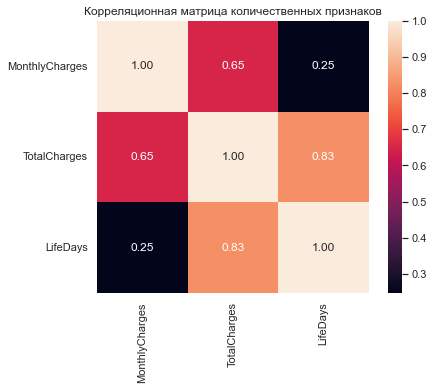

In [43]:
ax = sb.heatmap(
    X[["MonthlyCharges", "TotalCharges", "LifeDays"]].corr(), 
    annot=True, 
    fmt=".2f", 
    xticklabels=True, 
    yticklabels=True,
    square=True
)
ax.set_title("Корреляционная матрица количественных признаков")
ax.figure.set_size_inches(7, 5)

In [44]:
# TODO
def report_corr(df, a, b, alpha=.05):
    result = stats.spearmanr(df[[a, b]])
    print("Коэффициент корреляции: {:.2f}".format(result.correlation))
    print("p-value: {:.1e}".format(result.pvalue))
    if result.pvalue < alpha:
        print("Коэффициент корреляции статистически значим.")
    else:
        print("Коэффициент корреляции статистически несущественен.")

In [45]:
report_corr(X, "MonthlyCharges", "TotalCharges")

Коэффициент корреляции: 0.64
p-value: 0.0e+00
Коэффициент корреляции статистически значим.


In [46]:
report_corr(X, "LifeDays", "TotalCharges")

Коэффициент корреляции: 0.89
p-value: 0.0e+00
Коэффициент корреляции статистически значим.


**Шкала Чеддока**

Коэффициент корреляции|0,1—0,3|0,3—0,5|0,5—0,7|0,7—0,9|0,9—0,99
---|---|---|---|---|---
Характеристика зависимости|Слабая|Умеренная|Заметная|Высокая|Весьма высокая

Для признака 'TotalCharges', по шкале Чеддока, наблюдается статистически значимая заметная корреляция с признаком 'MonthlyCharges' и статистически значимая высокая корреляция с признаком 'LifeDays'. Признак 'TotalCharges' перед обудчением удалим для уклонения от проблем связанных с мультиколлинеарностью.

#### Количественные vs номинальные

Выделим номинальные признаки.

In [47]:
features_nominal = X.select_dtypes(["object", "Int8"]).columns
print("Количество категориальных прзнаков:", len(features_nominal))

Количество категориальных прзнаков: 18


In [48]:
def group_dst_equal(df, numeric, nominal, alpha=.05):
    categories = df[nominal].unique()
    
    for i, c1 in enumerate(categories[:-1]):
        for c2 in categories[i+1:]:
            test = stats.mannwhitneyu(
                df.loc[df[nominal] == c1, numeric], 
                df.loc[df[nominal] == c2, numeric]
            )
            
            # The distributions are not equal, i.e. F(u) ≠ G(u) for at least one u.
            if test.pvalue < alpha:
                return False
    return True

Признаки с одинаковыми общими и ежемесячными средними клиентскими счетами в категориях:

'gender'


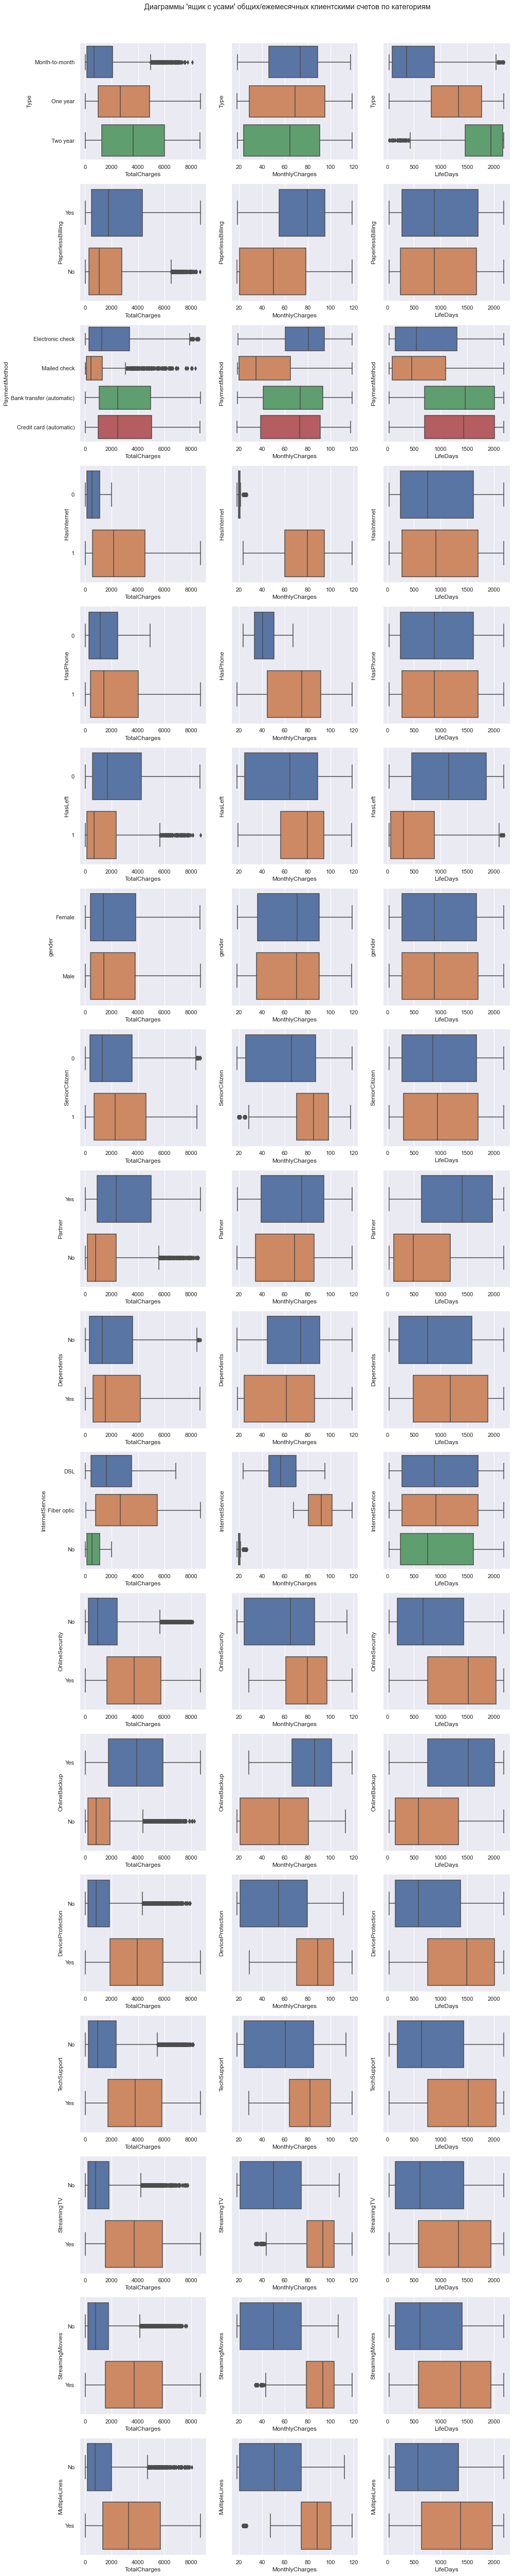

In [49]:
fig, axs = plt.subplots(18, 3, figsize=(15, 90))
fig.suptitle(
    "Диаграммы 'ящик с усами' общих/ежемесячных клиентскими счетов по категориям", 
    y=.89, 
    va="baseline"
)

count = 1
print("Признаки с одинаковыми общими и ежемесячными средними клиентскими счетами в категориях:\n")
for col, ax in zip(features_nominal, axs):
    if (group_dst_equal(X, "MonthlyCharges", col) 
        and group_dst_equal(X, "LifeDays", col)): 
        print("{!r}".format(col))
    sb.boxplot(data=X, x="TotalCharges",   y=col, ax=ax[0], orient="h")
    sb.boxplot(data=X, x="MonthlyCharges", y=col, ax=ax[1], orient="h")
    ax[1].set_yticklabels([])
    sb.boxplot(data=X, x="LifeDays", y=col, ax=ax[2], orient="h")
    _ = ax[2].set_yticklabels([])

Средние общих и ежемесячных клиентских счетов статистически равны, по критерию Манна-Уитни, только среди категорий признака 'gender'. В целом из диаграмм можно сделать и такой вывод: чем больше у клиента услуг, тем больше он платит компании. Иначе, чем больше клиент вовлечен в отношения с компанией, тем больше он приносит прибыли. Хотя вывод и очевидный, не лишним будет вспомнить об этом. 
 
Сравним количество ушедших/оставшихся клиентов по половаму признаку.

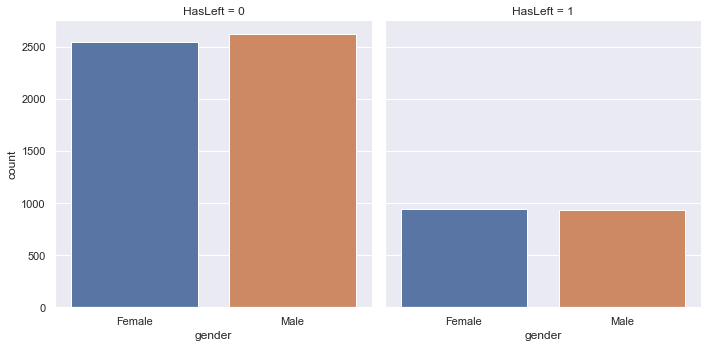

In [50]:
_ = sb.catplot(data=X, x='gender', col="HasLeft", kind="count")

Половая принадлежность клиентов вряд ли пригодится в обучении моделей.

#### Номинальные vs номинальные

Посмотрим на значения коэффициента контингеции Крамера для измерения степени взаимосвязи номинальных признаков

In [51]:
def report_nominals():
    contigency_lables = []
    contigency = []
    chi2 = []
    pvalue = []
    
    for i, left in enumerate(features_nominal[:-1]):
        for right in features_nominal[i + 1:]:
            ct = pd.crosstab(X[left], X[right])
            contigency_value = stats.contingency.association(ct, method="cramer")
            if contigency_value > .3:
                
                contigency_lables.append((left, right,))
                contigency.append(contigency_value)
                
                chi2_result = stats.chi2_contingency(ct)[:2]
                chi2.append(chi2_result[0])
                pvalue.append(chi2_result[1])
            
    contigency_df = pd.DataFrame(
        data={
            "contigency": contigency,
            "chi2_pvalue": pvalue,
            "chi2": chi2,
        },
        index=contigency_lables
    )
    contigency_df.index = pd.MultiIndex.from_tuples(contigency_lables)
    return contigency_df#.sort_values("contigency", ascending=False)

stats_nominal = report_nominals()
stats_nominal

contigency    chi2_pvalue         chi2
Type             HasLeft             0.409560  7.326182e-257  1179.545829
PaperlessBilling HasInternet         0.320592  7.487719e-159   721.160323
                 InternetService     0.377966  7.221949e-219  1004.578021
PaymentMethod    HasInternet         0.364217  6.712525e-202   932.825203
                 HasLeft             0.302960  1.426310e-139   645.429900
                 InternetService     0.312240  4.262322e-293  1371.155825
HasInternet      InternetService     1.000000   0.000000e+00  7032.000000
                 OnlineSecurity      0.332799  5.282652e-171   777.045598
                 OnlineBackup        0.380990  1.491130e-223  1018.773987
                 DeviceProtection    0.380151  1.409060e-222  1014.286446
                 TechSupport         0.335695  5.824907e-174   790.648369
                 StreamingTV         0.414951  7.740678e-265  1208.726564
                 StreamingMovies     0.418450  2.723445e-269  1229.219643
HasPhone         InternetService     0.452255   0.000000e+00  1438.288989
HasLeft          InternetService     0.321909  5.831199e-159   728.695614
Partner          Dependents          0.452269   0.000000e+00  1436.398280
InternetService  OnlineSecurity      0.393317  6.003421e-237  1087.840675
                 OnlineBackup        0.381212  1.245889e-222  1021.908083
                 DeviceProtection    0.380152  2.125947e-221  1016.234177
                 TechSupport         0.390560  1.197790e-233  1072.643697
                 StreamingTV         0.442688  5.674314e-300  1378.079156
                 StreamingMovies     0.442586  7.797339e-300  1377.443491
                 MultipleLines       0.369217  6.924923e-209   958.610315
OnlineSecurity   TechSupport         0.354458  8.981068e-194   881.776995
OnlineBackup     DeviceProtection    0.303058  3.500771e-142   644.505044
DeviceProtection TechSupport         0.332850  4.153426e-171   777.525971
                 StreamingTV         0.389924  3.898008e-234  1067.462401
                 StreamingMovies     0.402309  4.034101e-249  1136.408842
StreamingTV      StreamingMovies     0.533380   0.000000e+00  1998.315014

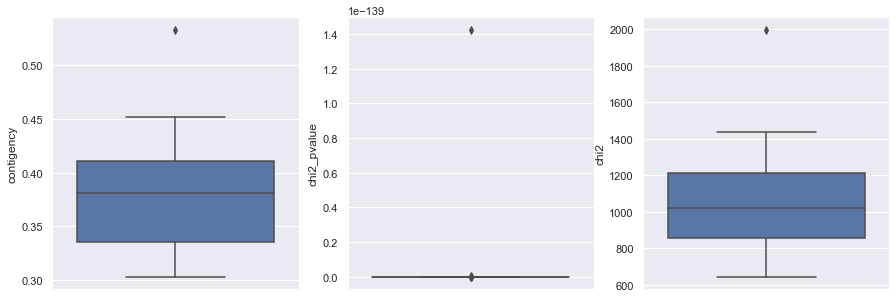

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(stats_nominal):
    sb.boxplot(
        data=stats_nominal.drop(index=[("HasInternet", "InternetService")]), 
        y=col, 
        ax=axs.flat[i]
    )

Все полученные коэффициенты контингенции в таблице выше статистически значимы.

Среди номинальных признаков есть не мало пар с коэффициентом контингенции в пределах (0.3; 0.46). Если коэффициент контингенции > 0,3, то считается, что между признаками существует корреля-
ционная связь. Хотя коэффициенты и говорят о наличии связи признаков, она не слишком велика и такие признаки я оставлю. 

Но есть и пара с коэффициентом контингеции 1: 'HasInternet', 'InternetService'. Признак 'HasInternet' можно удалить. Так же удалим 'StreamingMovies', который в паре с признаком 'StreamingTV' дает коэффициент 0.53.

#### Вывод

По итогам корреляционного анализа, стоит удалить признаки 'TotalCharges', 'gender', 'StreamingMovies' и 'HasInternet'. Так можно избежать проблем с мультиколлинеарностью без снижения качества моделей.

In [53]:
X = X.drop(columns=["TotalCharges", "gender", "HasInternet", "StreamingMovies"])

### Кодирование

Выделим зависимый и независимые признаки.

In [54]:
y = X["HasLeft"].astype(bool)

In [55]:
X = X.drop(columns=["HasLeft"])

Кодирование признаков упакуем в структуру, которую затем можно будет использовать как составную часть модели. 

In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), make_column_selector(dtype_include="object")),
        ("num", StandardScaler(), make_column_selector(dtype_include="number"))
    ]
)

# Check is preprocessor works correct
preprocessor.fit(X)
encoder = preprocessor.named_transformers_["cat"]
scaler = preprocessor.named_transformers_["num"]
print("[Категориальные признаки: категории]")
for i, (feature, categories) in enumerate(zip(encoder.feature_names_in_, encoder.categories_)):
    print("{:2} {:17}: {}".format(i+1, feature, ", ".join(categories)))
print("\n[Количественные признаки]")
for i, feature in enumerate(scaler.feature_names_in_):
    print("{:2} {:17}".format(i+1, feature))

[Категориальные признаки: категории]
 1 Type             : Month-to-month, One year, Two year
 2 PaperlessBilling : No, Yes
 3 PaymentMethod    : Bank transfer (automatic), Credit card (automatic), Electronic check, Mailed check
 4 Partner          : No, Yes
 5 Dependents       : No, Yes
 6 InternetService  : DSL, Fiber optic, No
 7 OnlineSecurity   : No, Yes
 8 OnlineBackup     : No, Yes
 9 DeviceProtection : No, Yes
10 TechSupport      : No, Yes
11 StreamingTV      : No, Yes
12 MultipleLines    : No, Yes

[Количественные признаки]
 1 MonthlyCharges   
 2 HasPhone         
 3 LifeDays         
 4 SeniorCitizen    


Преобразуем данные перед обучением.

In [57]:
X = pd.DataFrame(preprocessor.transform(X), index=X.index, columns=X.columns)

### Готовим выборки

Разделим данные на обучающую и тестовую выборки.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.2,
    shuffle=True,
    random_state=SEED,
    stratify=y
)

### Выводы

- Данные очищены
- Пропуски заполнены
- Категориальные признаки закодированы с помощью 'OrdinalEncoder'
- Кодирование и нормализация признаков собраны в единый модуль

*Примечание*:

Удаление признаков, выделение доп. признаков, заполнение пропусков можно также выделить в отдельный объект и объединить с 'preprocessor'ом в Pipeline, согласно шагам в этом параграфе. 

## Разработка модели

In [59]:
metrics = ["precision", "recall", "f1", "roc_auc", "accuracy"]

### Модель случайного леса

In [60]:
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=SEED)

In [61]:
rf_classifier_hptuner = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions={
        "n_estimators": range(100, 1001),
        "min_samples_split": range(2, 101),
        "min_samples_leaf": range(1, 101),
        "max_depth": range(5, 201),
        "criterion": ["gini", "entropy"]
    },
    n_iter=5,
    scoring=metrics,
    n_jobs=2,
    refit="roc_auc",
    cv=StratifiedKFold(shuffle=True, random_state=SEED),
    error_score='raise',
    random_state=SEED,
    verbose=3
)

### Модель градиентного бустинга

In [62]:
lgbm_classifier = lgb.LGBMClassifier(objective='binary', class_weight='balanced', random_state=SEED, n_jobs=1)

In [63]:
lgbm_classifier_hptuner = RandomizedSearchCV(
    estimator=lgbm_classifier,
    param_distributions={
        "n_estimators": range(100, 1001),
        "num_leaves": range(2, 201),
        "max_depth": range(5, 201),
        "learning_rate": [.0001, .0005, .001, .005, .01, .05, .1]
    },
    n_iter=5,
    scoring=metrics,
    n_jobs=2,
    refit="roc_auc",
    cv=StratifiedKFold(shuffle=True, random_state=SEED),
    error_score='raise',
    random_state=SEED,
    verbose=3
)

### Нейронная сеть

In [64]:
nn = Sequential(
    [layers.Dense(units=100, activation="relu", input_shape=(X.shape[1],)),
#      layers.Dense(units=100, activation="relu"),
     layers.Dense(units=1, activation='sigmoid')]
)

nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC", "acc"])

nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1700      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,801
Trainable params: 1,801
Non-trainable params: 0
_________________________________________________________________


### Проверочная

In [65]:
dummy = GridSearchCV(
    estimator=DummyClassifier(random_state=SEED),
    param_grid={
        "strategy": ["stratified", "most_frequent", "prior", "uniform"]
    },
    scoring="roc_auc",
    n_jobs=2,
    refit=True,
    cv=StratifiedKFold(shuffle=True, random_state=SEED),
    verbose=3
)

## Обучение

### Модель случайного леса

In [66]:
rf_classifier_hptuner.fit(X_train, y_train)

for param_name, param_value in rf_classifier_hptuner.best_params_.items():
    print("{}: {}".format(param_name, param_value))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
n_estimators: 208
min_samples_split: 45
min_samples_leaf: 15
max_depth: 24
criterion: gini


In [67]:
predictions_proba = rf_classifier_hptuner.predict_proba(X_test)[:, 1]
predictions = rf_classifier_hptuner.predict(X_test)
print("""\
Значение метрик на тестовой выборке

roc_auc: {:.2f}
precision: {:.0%}
recall: {:.0%}""".format(
        roc_auc_score(y_test, predictions_proba),
        precision_score(y_test, predictions),
        recall_score(y_test, predictions),
    )
)

Значение метрик на тестовой выборке

roc_auc: 0.86
precision: 56%
recall: 79%


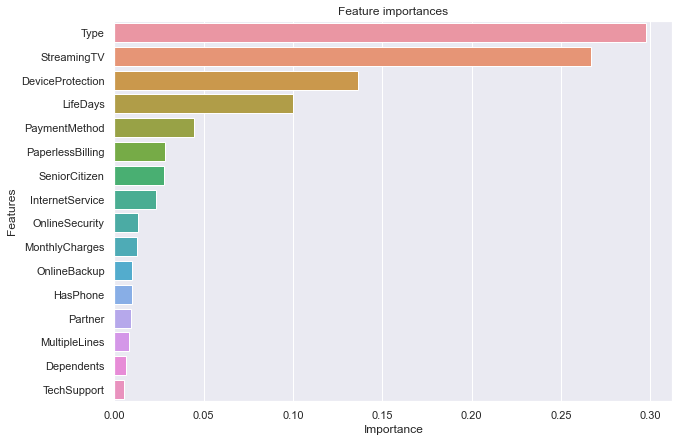

In [68]:
rf_importances = pd.DataFrame(
    data=rf_classifier_hptuner.best_estimator_.feature_importances_[np.newaxis, :],
    columns=X.columns
).sort_values(by=0, axis=1, ascending=False)

ax = sb.barplot(data=rf_importances, orient='h')
ax.set_title("Feature importances")
ax.set_xlabel("Importance")
ax.set_ylabel("Features")
ax.figure.set_size_inches(10, 7)

### Модель градиентного бустинга

In [69]:
lgbm_classifier_hptuner.fit(X_train, y_train)

for param_name, param_value in lgbm_classifier_hptuner.best_params_.items():
    print("{}: {}".format(param_name, param_value))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
num_leaves: 58
n_estimators: 467
max_depth: 173
learning_rate: 0.01


In [70]:
predictions_proba = lgbm_classifier_hptuner.predict_proba(X_test)[:, 1]
predictions = lgbm_classifier_hptuner.predict(X_test)
print("""\
Значение метрик на тестовой выборке

roc_auc: {:.2f}
precision: {:.0%}
recall: {:.0%}""".format(
        roc_auc_score(y_test, predictions_proba),
        precision_score(y_test, predictions),
        recall_score(y_test, predictions),
    )
)

Значение метрик на тестовой выборке

roc_auc: 0.90
precision: 64%
recall: 79%


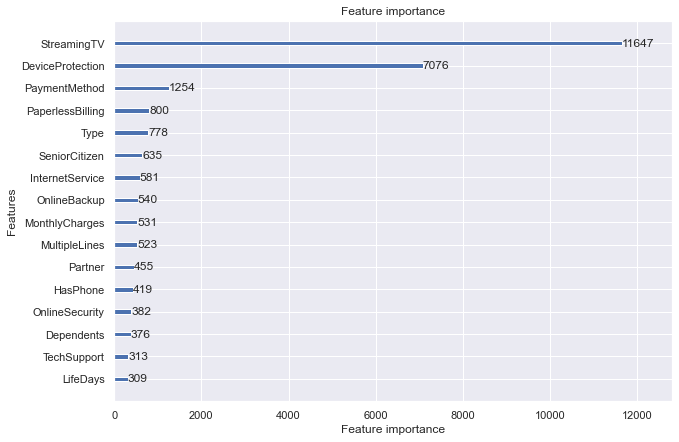

In [71]:
ax = lgb.plot_importance(
    lgbm_classifier_hptuner.best_estimator_, 
    figsize=(10, 7)
)


### Нейронная сеть

In [72]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, y_train,
    test_size=.2,
    shuffle=True,
    random_state=SEED,
    stratify=y_train
)

In [73]:
nn.fit(
    X_train_nn, y_train_nn, 
    validation_data=(X_val_nn, y_val_nn),
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor="val_auc", patience=4, mode="max", verbose=3, restore_best_weights=True)
    ],
    epochs=50, 
    verbose=2
)
print("\n\nОценка качества на тестовой выборке")
nn_loss, nn_roc_auc, nn_acc = nn.evaluate(X_test, y_test, batch_size=32)
print(
    "Значение метрики roc_auc на тестовой выборке: {:.2f}".format(nn_roc_auc)
)

Epoch 1/50
71/71 - 1s - loss: 0.4846 - auc: 0.7804 - acc: 0.7502 - val_loss: 0.4361 - val_auc: 0.8346 - val_acc: 0.7911 - 945ms/epoch - 13ms/step
Epoch 2/50
71/71 - 0s - loss: 0.4326 - auc: 0.8314 - acc: 0.7924 - val_loss: 0.4245 - val_auc: 0.8417 - val_acc: 0.7982 - 115ms/epoch - 2ms/step
Epoch 3/50
71/71 - 0s - loss: 0.4268 - auc: 0.8361 - acc: 0.7940 - val_loss: 0.4219 - val_auc: 0.8466 - val_acc: 0.7964 - 106ms/epoch - 1ms/step
Epoch 4/50
71/71 - 0s - loss: 0.4237 - auc: 0.8390 - acc: 0.7958 - val_loss: 0.4173 - val_auc: 0.8477 - val_acc: 0.8062 - 116ms/epoch - 2ms/step
Epoch 5/50
71/71 - 0s - loss: 0.4214 - auc: 0.8409 - acc: 0.8007 - val_loss: 0.4157 - val_auc: 0.8489 - val_acc: 0.8036 - 126ms/epoch - 2ms/step
Epoch 6/50
71/71 - 0s - loss: 0.4202 - auc: 0.8422 - acc: 0.7993 - val_loss: 0.4144 - val_auc: 0.8498 - val_acc: 0.8036 - 120ms/epoch - 2ms/step
Epoch 7/50
71/71 - 0s - loss: 0.4180 - auc: 0.8439 - acc: 0.8036 - val_loss: 0.4139 - val_auc: 0.8512 - val_acc: 0.8027 - 108ms/e

## Проверка на адекватность

In [74]:
dummy.fit(X_train, y_train)

for param_name, param_value in dummy.best_params_.items():
    print("{}: {}".format(param_name, param_value))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
strategy: most_frequent


In [75]:
predictions = dummy.predict(X_test)
print(
    "Значение метрики roc_auc на тестовой выборке: {:.2f}".format(roc_auc_score(y_test, predictions))
)

Значение метрики roc_auc на тестовой выборке: 0.50


## Выводы

Модель|roc_auc тест
---|---
RandomForestClassifier|0.86|
LGBMClassifier|0.90|
NeuralNetwork|0.85|
Dummy|0.5

- Разработано 3 модели
- Все модели значительно отличаются от наивной
- Наиболее важными для модели RandomForestClassifier оказались признаки: 

In [76]:
rf_importances.columns[:4].to_list()

['Type', 'StreamingTV', 'DeviceProtection', 'LifeDays']

- Наиболее важными для модели LGBMClassifier оказались признаки: 

In [77]:
pd.Series(
    lgbm_classifier_hptuner.best_estimator_.feature_importances_,
    index=lgbm_classifier_hptuner.best_estimator_.feature_name_
).sort_values(ascending=False).head(2).index.to_list()

['StreamingTV', 'DeviceProtection']

- Лучшая модель - LGBMClassifier

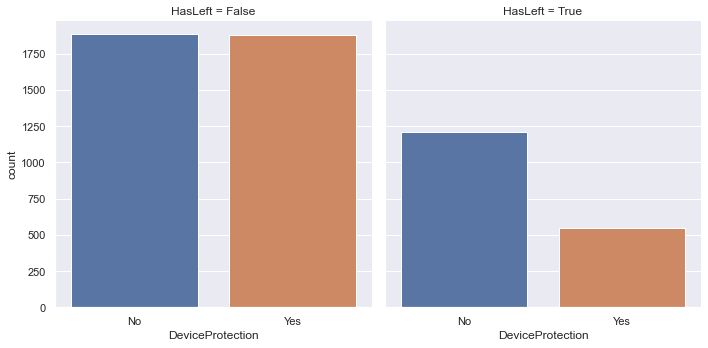

In [78]:
_ = sb.catplot(data=internet.join(contract),  x="DeviceProtection", col="HasLeft", kind='count')

Ушедшие клиенты меньше использовали услугу 'DeviceProtection' в отличае от оставшихся. Возможно, орудует банда мошенников и мешает клиентам и компании?